In [329]:
import scipy as sp
import scipy.stats as sps
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import jenkspy as jp
import math
from sklearn.manifold import MDS

In [330]:
NUM_VARS = 4
NUM_SETS = 6
# with two bins we have it guaranteed that the label of the cluster-defining variable equals to the cluster label
# using more bins this relationship can be obscured, i.e., that we have more than 1 label in the shifted cluster for that variable
NUM_BINS = 2

var_stats = {"mean": np.repeat(0, NUM_VARS), "sd": np.repeat(0.5, NUM_VARS)}
set_stats = [
    0.46,
    0.25,
    0.16,
    0.11,
    0.1,
    0.09,
]  # from imdb dataset - could also round this to nice numbers idk (.5, .25, .15, .1, .1, .1)

var_names = list(map(lambda i: f"V{i}", range(NUM_VARS)))  # raw value
varz_names = list(
    map(lambda vn: f"{vn}_z", var_names)
)  # min-max normalized value (for glyph drawing, perhaps)
varb_names = list(
    map(lambda vn: f"{vn}_b", var_names)
)  # fisher-jenks bin (also for glyph drawing)

set_names = list(map(lambda i: f"S{i}", range(NUM_SETS)))


In [361]:
def mvnorm(means, sds, size=10, random_state=None):
    dist = sps.multivariate_normal(means, sds)
    return dist.rvs(size=size, random_state=random_state)


def uniform(loc=0, scale=1, size=10, random_state=None):
    dist = sps.uniform(loc=loc, scale=scale)
    return dist.rvs(size=size, random_state=random_state)


def rvs(means, sds, limits, size=10, random_state=None):
    """Returns samples of D truncated normal distributions with the provided means, SDs and limits.
    The distributions are assumed to be independent, hence each dimension is sampled individually.
    The provided limits are assumed to be in sample space (as opposed to standard deviations).
    Note that SD and limits are dependent, i.e., if the limits are too narrow, the SD of the resulting
    distribution will be smaller than what was asked for."""
    D = min(len(means), len(sds), len(limits))
    result = np.empty((size, D))
    for i in range(D):
        l = limits[i][0]
        r = limits[i][1]
        m = means[i]
        s = sds[i]
        a, b = (l - m) / s, (r - m) / s
        samples = sps.truncnorm.rvs(
            a, b, loc=m, scale=s, size=size, random_state=random_state
        )
        result[:, i] = samples
    return result

In [389]:
means = var_stats["mean"]
sds = var_stats["sd"]


def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))


def get_loc_from_shift_dir(dir):
    match dir:
        case 0:
            return 0
        case -1:
            return 0
        case 1:
            return 0.8


def get_scale_from_shift_dir(dir):
    match dir:
        case 0:
            return 1
        case -1:
            return 0.2
        case 1:
            return 0.2


def value_fits_dir(value, dir):
    match dir:
        case 0:
            return True
        case -1:
            return value >= 0 and value <= 0.25
        case 1:
            return value >= 0.8 and value <= 1


def make_dataset(
    cluster1_size=20,
    cluster2_size=5,
    cluster2_shift_direction=[],
):
    limits = np.broadcast_to((0, 1), (NUM_VARS, 2))
    cluster_defining_vars = list(
        [(i, d) for i, d in enumerate(cluster2_shift_direction) if d != 0]
    )
    # samples1 = mvnorm(means, sds, size=cluster1_size)
    samples1 = np.transpose(
        np.array([uniform(size=cluster1_size) for i in range(NUM_VARS)])
    )
    samples2 = np.transpose(
        np.array(
            [
                uniform(
                    loc=get_loc_from_shift_dir(cluster2_shift_direction[i]),
                    scale=get_scale_from_shift_dir(cluster2_shift_direction[i]),
                    size=cluster2_size,
                )
                for i in range(NUM_VARS)
            ]
        )
    )

    # go through cluster 1 and make sure that no data point has the same characteristics that define cluster 2
    # otherwise there would be systematic errors in the study results (participants answer correctly but we count it as erroneous)
    for j in range(samples1.shape[0]):
        while all(
            [value_fits_dir(samples1[j, v], dir) for v, dir in cluster_defining_vars]
        ):
            for v, _ in cluster_defining_vars:
                samples1[j, v] = uniform(size=1)[0]

    samples = np.concatenate((samples1, samples2))

    data = {}
    for i in range(NUM_VARS):
        x = samples[:, i]
        xz = norm(x)
        data[f"V{i}"] = x
        data[f"V{i}_z"] = xz
        jnb = jp.JenksNaturalBreaks(NUM_BINS)
        jnb.fit(x)
        data[f"V{i}_b"] = jnb.labels_

    data["cluster"] = np.concatenate(
        (np.repeat(0, cluster1_size), np.repeat(1, cluster2_size))
    )
    df = pd.DataFrame(data=data)

    for i in range(NUM_SETS):
        freq = set_stats[i]
        df[f"S{i}"] = sps.binom.rvs(1, freq, size=cluster1_size + cluster2_size)

    # now a bit of postprocessing regarding sets
    set_names = list(map(lambda i: f"S{i}", range(NUM_SETS)))
    # we want all sets to have at least one element in each cluster
    # which at the same time ensures that no set has a single or no element
    genre_colsums = df[set_names + ["cluster"]].groupby("cluster").sum()
    for cluster in range(2):
        for genre in set_names:
            count = genre_colsums.loc[cluster, genre]
            if count == 0:
                # take random row of that cluster and add the set there
                randrow_start = 0 if cluster == 0 else cluster1_size
                randrow_end = (
                    cluster1_size if cluster == 0 else cluster1_size + cluster2_size
                )
                randrow = np.random.choice(
                    range(randrow_start, randrow_end), 1, replace=False
                )
                df.loc[randrow[0], genre] = 1
    # do the same sort of thing row-wise
    # there could be movies not in any set/genre, and we don't want that
    for i in range(df.shape[0]):
        while df.loc[i][set_names].sum() < 1:
            for j, genre in enumerate(set_names):
                # do the drawing again
                freq = set_stats[j]
                flag = sps.binom.rvs(1, freq, size=1)
                df.loc[i, genre] = flag

    return df

In [397]:
dataset = make_dataset(cluster2_shift_direction=[0, 1, -1, 0])
dataset


,V0,V0_z,V0_b,V1,V1_z,V1_b,V2,V2_z,V2_b,V3,V3_z,V3_b,cluster,S0,S1,S2,S3,S4,S5
0,0.051911,0.033460,0,0.593215,0.582277,1,0.783941,0.804838,1,0.298716,0.306573,0,0,1,0,0,0,0,0
1,0.909360,0.950071,1,0.066308,0.026547,0,0.011046,0.000000,0,0.452479,0.465982,0,0,0,1,0,0,1,1
2,0.059647,0.041729,0,0.737127,0.734060,1,0.362363,0.365837,0,0.845680,0.873620,1,0,1,0,0,0,0,0
3,0.576648,0.594403,1,0.495240,0.478943,1,0.018382,0.007640,0,0.188053,0.191847,0,0,1,0,0,0,1,0
4,0.949647,0.993138,1,0.138639,0.102835,0,0.628817,0.643304,1,0.744077,0.768286,1,0,0,1,0,0,0,0
5,0.321349,0.321489,0,0.076750,0.037560,0,0.435909,0.442423,1,0.967584,1.000000,1,0,1,1,0,0,0,0
6,0.799918,0.833078,1,0.351895,0.327756,0,0.166899,0.162294,0,0.300640,0.308567,0,0,0,1,0,0,1,0
7,0.102203,0.087222,0,0.571251,0.559112,1,0.033541,0.023425,0,0.290550,0.298107,0,0,1,0,0,0,0,0
8,0.610877,0.630994,1,0.218181,0.186728,0,0.550044,0.561274,1,0.479124,0.493605,0,0,0,0,0,1,0,0
9,0.488580,0.500258,1,0.803223,0.803773,1,0.670312,0.686514,1,0.691207,0.713475,1,0,0,0,1,0,0,0


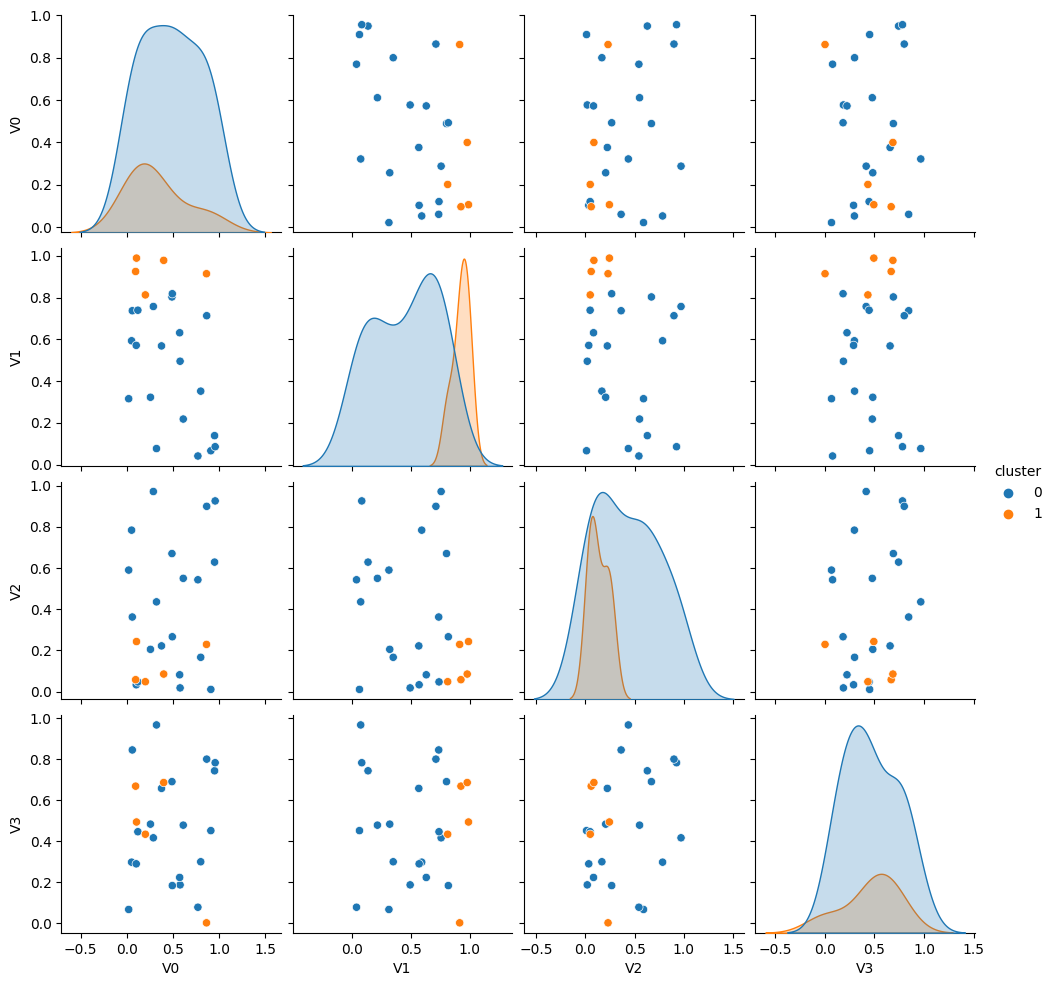

In [398]:
sns.pairplot(dataset[var_names + ["cluster"]], hue="cluster")

/usr/local/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


<Axes: xlabel='mdsx', ylabel='mdsy'>

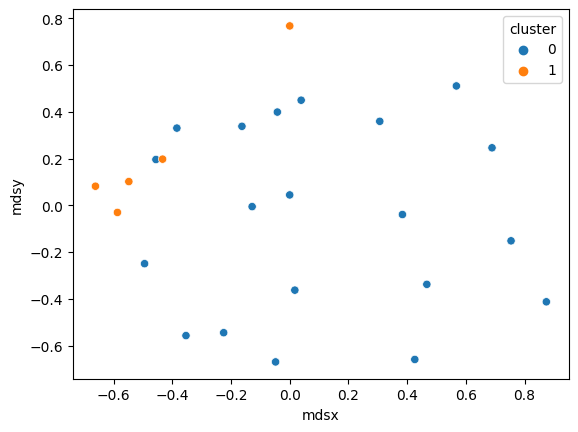

In [399]:
# quickly check the projection - we want the orange points bunched together
mds = MDS(n_components=2, metric=True, random_state=2, dissimilarity="euclidean")
# H_mds = mds.fit_transform(sps.zscore(dataset[varz_names]))
H_mds = mds.fit_transform(dataset[var_names])

sns.scatterplot(
    pd.DataFrame(
        data={
            "mdsx": H_mds[:, 0],
            "mdsy": H_mds[:, 1],
            "cluster": dataset["cluster"],
        }
    ),
    x="mdsx",
    y="mdsy",
    hue="cluster",
)

In [400]:
dataset


,V0,V0_z,V0_b,V1,V1_z,V1_b,V2,V2_z,V2_b,V3,V3_z,V3_b,cluster,S0,S1,S2,S3,S4,S5
0,0.051911,0.033460,0,0.593215,0.582277,1,0.783941,0.804838,1,0.298716,0.306573,0,0,1,0,0,0,0,0
1,0.909360,0.950071,1,0.066308,0.026547,0,0.011046,0.000000,0,0.452479,0.465982,0,0,0,1,0,0,1,1
2,0.059647,0.041729,0,0.737127,0.734060,1,0.362363,0.365837,0,0.845680,0.873620,1,0,1,0,0,0,0,0
3,0.576648,0.594403,1,0.495240,0.478943,1,0.018382,0.007640,0,0.188053,0.191847,0,0,1,0,0,0,1,0
4,0.949647,0.993138,1,0.138639,0.102835,0,0.628817,0.643304,1,0.744077,0.768286,1,0,0,1,0,0,0,0
5,0.321349,0.321489,0,0.076750,0.037560,0,0.435909,0.442423,1,0.967584,1.000000,1,0,1,1,0,0,0,0
6,0.799918,0.833078,1,0.351895,0.327756,0,0.166899,0.162294,0,0.300640,0.308567,0,0,0,1,0,0,1,0
7,0.102203,0.087222,0,0.571251,0.559112,1,0.033541,0.023425,0,0.290550,0.298107,0,0,1,0,0,0,0,0
8,0.610877,0.630994,1,0.218181,0.186728,0,0.550044,0.561274,1,0.479124,0.493605,0,0,0,0,0,1,0,0
9,0.488580,0.500258,1,0.803223,0.803773,1,0.670312,0.686514,1,0.691207,0.713475,1,0,0,0,1,0,0,0


In [337]:
import os.path as osp

dpi = 300


def make_glyphs(name, mdf):
    result = []
    for i in mdf.index:
        datacase = mdf.loc[i]
        angles = [n / float(NUM_VARS) * 2 * math.pi for n in range(NUM_VARS)] + [0]
        values = [datacase[varz_names[j]] for j in range(NUM_VARS)] + [
            datacase[varz_names[0]]
        ]

        ax = plt.subplot(111, polar=True)
        ax.figure.patch.set_alpha(0)
        ax.figure.set_size_inches(1, 1)
        ax.set_ylim(bottom=0, top=1)
        ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
        ax.set_xticks(np.pi / 180.0 * np.linspace(180, -180, NUM_VARS, endpoint=False))
        ax.set_thetalim(-np.pi, np.pi)
        ax.spines[:].set_linewidth(0.5)

        ax.plot(angles, values, linewidth=0, linestyle="solid")
        ax.fill(angles, values, "k", alpha=1)

        plt.tick_params(
            grid_linestyle="dashed",
            grid_linewidth=0.5,
            left=False,
            right=False,
            bottom=False,
            top=False,
            labelleft=False,
            labelright=False,
            labelbottom=False,
            labeltop=False,
        )

        plt.tight_layout(pad=-1)
        filename = f"./img/{name}_{i}_thumb.png"
        plt.savefig(filename, dpi=dpi, bbox_inches="tight", transparent=False)
        plt.clf()
        result.append(osp.join("eval/dataset", filename))
    return result


In [396]:
import json
import random
import scipy.spatial.distance as scidist
from itertools import combinations

NUM_DATASETS = 2

# category = mv, hg, mvhg
# in each cat: ask for cluster defining (1) or not (0) variables/sets
# so eg if shift dir is [0, -1, 1, 0]
# (mv, cluster-defining, bins={v1: (0), v2: (2)})


for i in range(NUM_DATASETS):
    ds_name = f"dataset{i}"
    num_cluster_defining_vars = 2
    cluster_defining_vars = random.sample(range(NUM_VARS), k=num_cluster_defining_vars)
    cluster_defining_direction = random.choices([-1, 1], k=num_cluster_defining_vars)
    cluster_definers = zip(cluster_defining_vars, cluster_defining_direction)

    shift_direction = np.repeat(0, NUM_VARS)
    for v, d in cluster_definers:
        shift_direction[v] = d

    print("shift dataset", i, shift_direction)

    cluster1_size = random.randint(13, 17)
    cluster2_size = 20 - cluster1_size

    df = make_dataset(
        cluster1_size=cluster1_size,
        cluster2_size=cluster2_size,
        cluster2_shift_direction=shift_direction,
    )

    df.to_csv(f"{ds_name}.csv", index=False)

    glyphs = make_glyphs(ds_name, df)

    ds_dists = scidist.squareform(scidist.pdist(df[var_names], scidist.euclidean))
    set_dists = scidist.squareform(scidist.pdist(df[set_names], scidist.jaccard))

    sets_per_row = []
    for j in df.index:
        sets_per_row.append([g for g in set_names if df.loc[j, g] == 1])

    with open(f"{ds_name}_meta.json", "w") as f:
        json.dump(
            {
                "cluster_defining_vars": cluster_defining_vars,
                "cluster_defining_direction": cluster_defining_direction,
            },
            f,
        )

    with open(f"{ds_name}.json", "w", encoding="utf8") as f:
        jsonstr = {
            "glyph_ids": glyphs,
            "E": list(
                map(lambda x: str(x), df.index.tolist())
            ),  # TODO definitely remove this before producing the actual datasets
            "EA": ds_dists.tolist(),
            "SR": sets_per_row,
            "S": set_names,
            "SA": set_dists.tolist(),
        }
        json.dump(jsonstr, f, ensure_ascii=False)

shift dataset 0 [1 0 1 0]
shift dataset 1 [0 0 1 1]


<Figure size 100x100 with 0 Axes>